# Calculate Automation Probabilities of Jobs on the Swiss Labour Market

## Content
1. [Import Data](#import)
2. [Normalize the Data](#normalize)
3. [Calculate Weighted Sum from Coefficients](#weighted-sum)
4. [Calculate Probability of Automation](#probability)
5. [Display Results](#display)
6. [Save Results](#save)

In [429]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math as m

<a id='import'></a>
## Import Data

In [430]:
# Replace 'filename.csv' with the path to your CSV file
df_swiss_jobs = pd.read_csv('files/switzerland_occupations.csv')
coefficients_outside_95 = pd.read_csv('files/coefficients.csv')
intercept = pd.read_csv('files/intercept.csv').iloc[0, 0]
not_automatable = [item[0] for item in pd.read_csv("files/not_automatable.csv").values.tolist()]

In [431]:
df_swiss_jobs.head(2)

,isco08,Name_de,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,...,a43,a44,a45,a46,a47,a48,a49,a50,a51,a52
0,2655,Schauspieler,2,0.72,0.72,0.69,0.69,0.50,0.50,0.50,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2612,Richter,2,0.81,0.75,0.81,0.72,0.81,0.66,0.56,...,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [432]:
coefficients_outside_95.head(2)

,id,coefficient
0,a12,-0.809382
1,s6,-0.701232


In [433]:
cols_to_keep = not_automatable
cols_to_keep.extend(['isco08', 'Name_de', 'Berufshauptgruppe'])

# Drop the other columns
df_swiss_jobs = df_swiss_jobs[cols_to_keep]

# Display the first few rows of the DataFrame
df_swiss_jobs.head(2)

,s4,s27,a5,s15,s8,s31,s26,s24,a12,a13,isco08,Name_de,Berufshauptgruppe
0,0.69,0.0,0.72,0.38,0.47,0.0,0.0,0.06,0.47,0.47,2655,Schauspieler,2
1,0.72,0.0,0.81,0.56,0.72,0.0,0.0,0.19,0.78,0.81,2612,Richter,2


<a id='normalize'></a>
## Normalize the Data

In [434]:
# Initialize a scaler
scaler = StandardScaler()

# Define the columns to scale
cols_to_scale = [col for col in df_swiss_jobs.columns if col not in ['isco08', 'Name_de',"Berufshauptgruppe"]]

# Scale only these columns
df_swiss_jobs_scaled = df_swiss_jobs.copy()
df_swiss_jobs_scaled[cols_to_scale] = scaler.fit_transform(df_swiss_jobs[cols_to_scale])

df_swiss_jobs_scaled.head(2)

,s4,s27,a5,s15,s8,s31,s26,s24,a12,a13,isco08,Name_de,Berufshauptgruppe
0,1.329989,-0.478152,0.761482,-0.154766,-0.453849,-1.464599,-1.08397,-1.190280,-1.135638,-0.898542,2655,Schauspieler,2
1,1.584277,-0.478152,1.356826,1.142521,1.502201,-1.464599,-1.08397,0.329845,1.552699,1.890494,2612,Richter,2


<a id='weighted-sum'></a>
## Calculate Weighted Sum from Coefficients

In [435]:
# Create a dictionary from the coefficients DataFrame
coef_dict = coefficients_outside_95.set_index('id')['coefficient'].to_dict()

print(coef_dict["s31"])

0.0280082924110774


In [436]:
# calculate weighted sums
ignore_cols = ['Name_de', 'isco08', 'Berufshauptgruppe']
weighted_sums = []

for index, row in df_swiss_jobs_scaled.iterrows():
    sum = 0
    for col_name, col_value in row.items():
        if col_name not in ignore_cols:
            sum += coef_dict[col_name] * col_value
    weighted_sums.append(sum)

# Create a new DataFrame for the weighted sums
df_swiss_jobs_scaled["weighted_sum"] = pd.DataFrame(weighted_sums)

df_swiss_jobs_scaled.head(2)

,s4,s27,a5,s15,s8,s31,s26,s24,a12,a13,isco08,Name_de,Berufshauptgruppe,weighted_sum
0,1.329989,-0.478152,0.761482,-0.154766,-0.453849,-1.464599,-1.08397,-1.190280,-1.135638,-0.898542,2655,Schauspieler,2,0.051064
1,1.584277,-0.478152,1.356826,1.142521,1.502201,-1.464599,-1.08397,0.329845,1.552699,1.890494,2612,Richter,2,-1.431423


<a id='probability'></a>
## Calculate Probability of Automation

In [437]:
# Calculate the probabilities
prob_list = [m.exp(x_i + intercept) / (1 + m.exp(x_i + intercept)) for x_i in df_swiss_jobs_scaled['weighted_sum']]

In [438]:
# Add the probabilities to the DataFrame
df_swiss_jobs_scaled['probability'] = prob_list

df_swiss_jobs_scaled.head(5)

,s4,s27,a5,s15,s8,s31,s26,s24,a12,a13,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,1.329989,-0.478152,0.761482,-0.154766,-0.453849,-1.464599,-1.083970,-1.190280,-1.135638,-0.898542,2655,Schauspieler,2,0.051064,0.461845
1,1.584277,-0.478152,1.356826,1.142521,1.502201,-1.464599,-1.083970,0.329845,1.552699,1.890494,2612,Richter,2,-1.431423,0.163091
2,-0.534788,2.095368,0.959930,-0.154766,0.798023,0.792444,1.302311,1.382239,1.032376,1.152220,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,-0.741104,0.279874
3,-0.280500,-0.478152,0.959930,0.277663,1.736927,-1.464599,-1.083970,0.680643,1.292537,1.644402,2120,"Mathematiker, Aktuare und Statistiker",2,-0.529246,0.324487
4,1.838564,-0.478152,0.959930,0.926306,0.798023,-1.464599,-0.909364,0.329845,1.032376,0.413946,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,-0.941437,0.241327


<a id='display'></a>
## Display Results

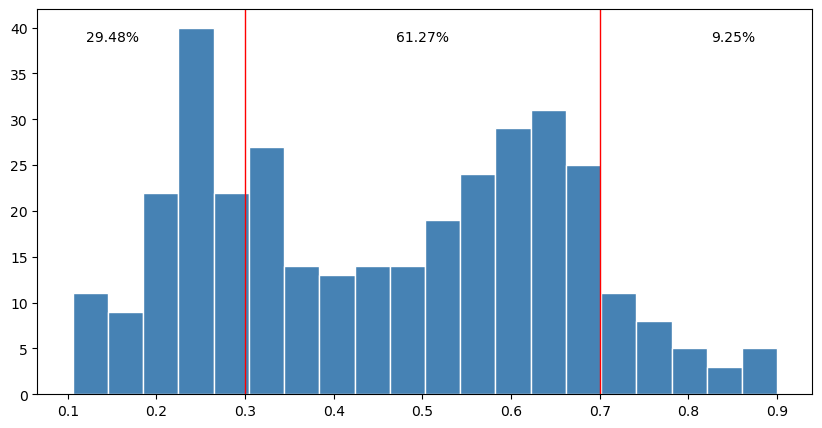

In [439]:
# Get the values
x = df_swiss_jobs_scaled["probability"].values

# Set the size of the plot
plt.figure(figsize=(10, 5))

# Calculate the histogram
hist, bins = np.histogram(x, bins=20)

# Calculate the width and center of the bars
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# Plot the histogram
plt.bar(center, hist, align='center', width=width, color='#4682B4', edgecolor='white')

# Add lines at 0.3 and 0.7
plt.axvline(0.3, color='r', linewidth=1)
plt.axvline(0.7, color='r', linewidth=1)

# Calculate the percentage of jobs between 0 and 0.3, 0.3 and 0.7, 0.7 and 1
percentage_0_03 = (x <= 0.3).mean() * 100
percentage_03_07 = ((0.3 < x) & (x < 0.7)).mean() * 100
percentage_07_1 = (x >= 0.7).mean() * 100

# Add the percentages to the plot
plt.text(0.15, max(hist) - 1, f'{percentage_0_03:.2f}%', ha='center', va='center', color='black')
plt.text(0.5, max(hist) - 1, f'{percentage_03_07:.2f}%', ha='center', va='center', color='black')
plt.text(0.85, max(hist) - 1, f'{percentage_07_1:.2f}%', ha='center', va='center', color='black')

# Show the plot
plt.show()

In [440]:
# Jobs with probability below 0.3
jobs_below_03 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] <= 0.3]
print(f"Number of jobs with probability below 0.3: {len(jobs_below_03)}")

# Jobs with probability between 0.3 and 0.7
jobs_between_03_and_07 = df_swiss_jobs_scaled[(df_swiss_jobs_scaled['probability'] > 0.3) & (df_swiss_jobs_scaled['probability'] <= 0.7)]
print(f"Number of jobs with probability between 0.3 and 0.7: {len(jobs_between_03_and_07)}")

# Jobs with probability above 0.7
jobs_above_07 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] > 0.7]
print(f"Number of jobs with probability above 0.7: {len(jobs_above_07)}")

Number of jobs with probability below 0.3: 102
Number of jobs with probability between 0.3 and 0.7: 212
Number of jobs with probability above 0.7: 32


In [441]:
df_swiss_jobs_scaled.head(100)

,s4,s27,a5,s15,s8,s31,s26,s24,a12,a13,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,1.329989,-0.478152,0.761482,-0.154766,-0.453849,-1.464599,-1.083970,-1.190280,-1.135638,-0.898542,2655,Schauspieler,2,0.051064,0.461845
1,1.584277,-0.478152,1.356826,1.142521,1.502201,-1.464599,-1.083970,0.329845,1.552699,1.890494,2612,Richter,2,-1.431423,0.163091
2,-0.534788,2.095368,0.959930,-0.154766,0.798023,0.792444,1.302311,1.382239,1.032376,1.152220,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,-0.741104,0.279874
3,-0.280500,-0.478152,0.959930,0.277663,1.736927,-1.464599,-1.083970,0.680643,1.292537,1.644402,2120,"Mathematiker, Aktuare und Statistiker",2,-0.529246,0.324487
4,1.838564,-0.478152,0.959930,0.926306,0.798023,-1.464599,-0.909364,0.329845,1.032376,0.413946,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,-0.941437,0.241327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.329989,-0.478152,0.563034,0.710092,0.015603,-1.464599,-1.083970,0.329845,0.772214,0.167854,2653,Tänzer und Choreografen,2,-0.855495,0.257410
96,-0.534788,-0.478152,0.761482,-0.154766,0.015603,-0.200655,-0.909364,0.329845,1.032376,0.167854,3112,Bauführer und Bautechniker,3,-0.736063,0.280891
97,0.567125,-0.478152,1.621423,0.926306,0.798023,-1.329177,-0.909364,0.329845,1.292537,1.398311,3315,Schätzer und Schadensgutachter,3,-1.301495,0.181610
98,-2.145278,0.440962,-2.347536,-1.091696,-1.940447,0.792444,0.720291,-1.190280,-1.135638,-1.636816,9112,"Reinigungspersonal und Hilfskräfte in Büros, H...",9,0.705592,0.622838


<a id='save'></a>
## Save Results

In [442]:
df_probabilities = df_swiss_jobs_scaled[['Name_de', 'Berufshauptgruppe', 'probability', "isco08"]].copy()
df_pytorch_model = df_swiss_jobs_scaled.drop(columns=["weighted_sum"])

In [443]:
df_probabilities['probability'] = df_probabilities['probability'].round(4)
df_probabilities.to_csv('files/switzerland_probabilities.csv', index=False)